In [2]:
import pandas as pd
import numpy as np
import regex, re, sys, nltk, csv 

from nltk import word_tokenize, sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.models import Nmf
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from operator import itemgetter
from collections import Counter

import matplotlib.pyplot as plt

from pathlib import Path

src_path = str(Path.cwd().parent / "src")
sys.path.append(src_path)
# python file with all the functions (located in the src folder)
import topic_classification as tc

In [3]:
filepath = Path.cwd().parent / "speeches_csv" / "all_speeches_cleaned.txt"
df=pd.read_csv(filepath, usecols=['title','content'])
df.head()

,title,content
0,CGI_2013,Hillary Clinton: Thank you very much. I have t...
1,Prayer_Breakfast_2016,"Well, good morning. Giving all praise and hono..."
2,Security_Team_Announcement,"Good morning, everybody. I hope you all had a ..."
3,Cairo_University,Thank you so much. Good afternoon. I am honore...
4,Umpqua_Community_College_Shootings,There's been another mass shooting in America ...


In [4]:
df['text']=df['content'].str.lower()
df.head()

,title,content,text
0,CGI_2013,Hillary Clinton: Thank you very much. I have t...,hillary clinton: thank you very much. i have t...
1,Prayer_Breakfast_2016,"Well, good morning. Giving all praise and hono...","well, good morning. giving all praise and hono..."
2,Security_Team_Announcement,"Good morning, everybody. I hope you all had a ...","good morning, everybody. i hope you all had a ..."
3,Cairo_University,Thank you so much. Good afternoon. I am honore...,thank you so much. good afternoon. i am honore...
4,Umpqua_Community_College_Shootings,There's been another mass shooting in America ...,there's been another mass shooting in america ...


In [5]:
# tokenize into sentences
df['tokenized']=df['text'].apply(lambda text: nltk.sent_tokenize(text))
df[['text','tokenized']].head()

,text,tokenized
0,hillary clinton: thank you very much. i have t...,"[hillary clinton: thank you very much., i have..."
1,"well, good morning. giving all praise and hono...","[well, good morning., giving all praise and ho..."
2,"good morning, everybody. i hope you all had a ...","[good morning, everybody., i hope you all had ..."
3,thank you so much. good afternoon. i am honore...,"[thank you so much., good afternoon., i am hon..."
4,there's been another mass shooting in america ...,[there's been another mass shooting in america...


In [6]:
# the '\b(?!\d)' filters out expressions like '9th', since the first character cannot be a number
tokenizer = RegexpTokenizer(r'\b(?!\d)[a-zA-Z]+')
lemmatizer = WordNetLemmatizer()
df['normalized']=df['tokenized'].apply(lambda text: tc.normalize_text(text, tokenizer, lemmatizer))
df[['text','tokenized','normalized']].head()

,text,tokenized,normalized
0,hillary clinton: thank you very much. i have t...,"[hillary clinton: thank you very much., i have...",hillary clinton thank you very much i have th...
1,"well, good morning. giving all praise and hono...","[well, good morning., giving all praise and ho...",well good morning give all praise and honor t...
2,"good morning, everybody. i hope you all had a ...","[good morning, everybody., i hope you all had ...",good morning everybody i hope you all have a ...
3,thank you so much. good afternoon. i am honore...,"[thank you so much., good afternoon., i am hon...",thank you so much good afternoon i be honor t...
4,there's been another mass shooting in america ...,[there's been another mass shooting in america...,there s be another mass shooting in america t...


In [7]:
STOPWORDS = set(stopwords.words('english'))
df['fully_processed'] = df['normalized'].apply(lambda text: tc.remove_stopwords(text, STOPWORDS))
                
cnt = Counter()
for text in df['fully_processed'].values:
    # counts the number of speeches the word is in
    for word in set(text.split()):
        cnt[word] += 1
# words that are in most of the speeches
in_most_speeches = cnt.most_common(155)
in_most_speeches = [x[0] for x in in_most_speeches]

extra = ['mr', 'question', 'sure', 'obama', 'really', 'try', 'lot', 'important', 'million', 'talk', 'va', 'dr', 'romney',
        'folk', 'governor', 'republican', 'king', 'heart'] 

STOPWORDS_extra = set(in_most_speeches + extra)
# remove some words from the stopwords list that migth be important
STOPWORDS_extra = STOPWORDS_extra - set(['war', 'care', 'child', 'family', 'job', 'law', 'protect', 'security', 'power'])

df['fully_processed'] = df['fully_processed'].apply(lambda text: tc.remove_stopwords(text, STOPWORDS_extra))
df[['text','tokenized','normalized','fully_processed']].head()

,text,tokenized,normalized,fully_processed
0,hillary clinton: thank you very much. i have t...,"[hillary clinton: thank you very much., i have...",hillary clinton thank you very much i have th...,hillary clinton pleasure introduce speaker con...
1,"well, good morning. giving all praise and hono...","[well, good morning., giving all praise and ho...",well good morning give all praise and honor t...,morning praise honor god morning everyone orga...
2,"good morning, everybody. i hope you all had a ...","[good morning, everybody., i hope you all had ...",good morning everybody i hope you all have a ...,morning wonderful thanksgiving announce econom...
3,thank you so much. good afternoon. i am honore...,"[thank you so much., good afternoon., i am hon...",thank you so much good afternoon i be honor t...,afternoon honor timeless city cairo host remar...
4,there's been another mass shooting in america ...,[there's been another mass shooting in america...,there s be another mass shooting in america t...,mass shooting college oregon family mom dad ch...


Use gensim's nmf model to find the best number of topics (sklearn doesn't have a way to calculate the coherence score), and use this number of topics with the sklearn nmf model (sklearn can use tf-idf weights, while gensim can only use raw counts)

In [8]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = [text.split() for text in df['fully_processed'].values]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 65, 2))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        passes=20,
        kappa=.5,
        #minimum_probability=0.001,
        w_max_iter=500,
        h_max_iter=100,
        normalize=True,
        random_state=0
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

7


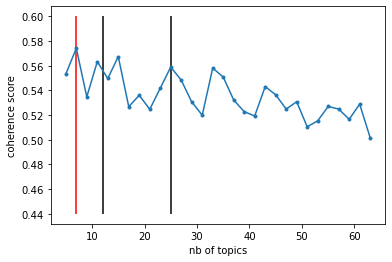

In [10]:
fig, ax = plt.subplots()
ax.plot(topic_nums, coherence_scores, '.-')
ax.set_xlabel('nb of topics')
ax.set_ylabel('coherence score');
ymin = 0.44
ymax = 0.6
plt.vlines(x=best_num_topics, ymin=ymin, ymax=ymax, color='r')
plt.vlines(x=25, ymin=ymin, ymax=ymax, color='k')
plt.vlines(x=12, ymin=ymin, ymax=ymax, color='k')
plt.show()

In [9]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=3, max_df=0.85, ngram_range=(1, 2), max_features=5000)
matrix = vectorizer.fit_transform(df['fully_processed'])
feature_names = vectorizer.get_feature_names_out()
vec_df = pd.DataFrame(matrix.toarray(), columns = feature_names)
vec_df

,abadi,abandon,abe,abide,ability,abraham,abraham lincoln,abroad,absence,absolute,...,yes,yes yes,yesterday,yield,york,york city,youth,zero,zika,zone
0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.004203,0.0,0.000000,0.000000,0.006305,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.026279,0.0,...,0.013992,0.0,0.017068,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.022109,0.000000,0.000000,0.029468,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.0,0.013335,0.0,0.022753,0.024863,0.015356,0.000000,0.000000,0.000000,0.0,...,0.007365,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.0,0.000000,0.0,0.060500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.009891,0.000000,0.0,...,0.000000,0.0,0.008044,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
432,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
433,0.0,0.013667,0.0,0.000000,0.008495,0.000000,0.000000,0.000000,0.000000,0.0,...,0.060387,0.0,0.000000,0.015739,0.000000,0.0,0.025159,0.0,0.087113,0.0
434,0.0,0.026268,0.0,0.000000,0.000000,0.000000,0.000000,0.021760,0.000000,0.0,...,0.014508,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [10]:
n_topics = 25 # 5 12 25
model = NMF(n_components=n_topics, init='nndsvda', max_iter=500)
model.fit(matrix)

NMF(init='nndsvda', max_iter=500, n_components=25)

In [11]:
n_top_words = 10
#fig, axes = plt.subplots(1, n_topics, figsize=(15, 5), sharex=True)
#axes = axes.flatten()
top_words = []
for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(top_features)
    top_words.append(top_features)
    weights = topic[top_features_ind]

    #ax = axes[topic_idx]
    #ax.barh(top_features, weights, height=0.7)
    #ax.set_title(f'Topic {topic_idx +1}',
    #                 fontdict={'fontsize': 14})
    #ax.invert_yaxis()
    #ax.tick_params(axis='both', which='major', labelsize=10)

['black', 'march', 'african', 'white', 'generation', 'justice', 'lincoln', 'story', 'civil', 'voting']
['tax', 'deficit', 'cut', 'job', 'spending', 'pay', 'business', 'economy', 'debt', 'tax cut']
['iran', 'nuclear', 'iranian', 'deal', 'nuclear weapon', 'weapon', 'sanction', 'program', 'nuclear program', 'iran nuclear']
['isil', 'syria', 'iraq', 'terrorist', 'iraqi', 'syrian', 'fighter', 'military', 'assad', 'coalition']
['insurance', 'health', 'care', 'health care', 'health insurance', 'coverage', 'affordable', 'insurance company', 'cost', 'affordable care']
['energy', 'oil', 'clean', 'clean energy', 'climate', 'job', 'gas', 'bp', 'carbon', 'industry']
['gun', 'background check', 'gun violence', 'background', 'check', 'violence', 'gun owner', 'newtown', 'law', 'owner']
['peace', 'war', 'human', 'nuclear', 'democracy', 'europe', 'africa', 'freedom', 'conflict', 'power']
['iraq', 'afghanistan', 'afghan', 'war', 'troop', 'military', 'iraqi', 'al', 'qaeda', 'al qaeda']
['intelligence', 't

In [12]:
t_df = pd.DataFrame(model.transform(matrix))
t_df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,0.03253,0.000000,0.0,0.412586,0.000859,0.000000,0.000000,0.000000,0.000000,...,0.000809,0.000000,0.00000,0.000000,0.002032,0.000000,0.000000,0.000000,0.000000,0.000
1,0.017296,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.011816,0.259886,0.140480,0.000000,0.000000,0.000
2,0.000000,0.00000,0.025044,0.0,0.000000,0.018676,0.000000,0.046410,0.096019,0.148231,...,0.000000,0.000000,0.00237,0.029518,0.005305,0.000000,0.000000,0.032279,0.016352,0.023
3,0.000000,0.00000,0.033797,0.0,0.000000,0.003943,0.000000,0.049345,0.036645,0.000000,...,0.000000,0.000000,0.00000,0.005530,0.000000,0.000000,0.424856,0.000000,0.000000,0.000
4,0.000000,0.00000,0.000000,0.0,0.000000,0.000613,0.299792,0.000000,0.000000,0.029010,...,0.000000,0.000661,0.00000,0.000000,0.000901,0.023271,0.000000,0.000000,0.000000,0.000


In [13]:
classification_df = pd.DataFrame(df.title.values, columns=["title"])
for i in range(1, n_topics + 1):
    topic = 'main_topic_' + str(i) 
    classification_df.loc[:, topic + '_index'] = t_df.apply(
        lambda row: row.nlargest(i).index.values[i-1] if row.nlargest(i).values[i-1] > 0 else 'none', axis=1)
    classification_df.loc[:, topic + '_weigth'] = t_df.apply(
        lambda row: row.nlargest(i).values[i-1] if row.nlargest(i).values[i-1] > 0 else 'none', axis=1)
classification_df

,title,main_topic_1_index,main_topic_1_weigth,main_topic_2_index,main_topic_2_weigth,main_topic_3_index,main_topic_3_weigth,main_topic_4_index,main_topic_4_weigth,main_topic_5_index,...,main_topic_21_index,main_topic_21_weigth,main_topic_22_index,main_topic_22_weigth,main_topic_23_index,main_topic_23_weigth,main_topic_24_index,main_topic_24_weigth,main_topic_25_index,main_topic_25_weigth
0,CGI_2013,4,0.412586,1,0.03253,10,0.002407,19,0.002032,5,...,none,none,none,none,none,none,none,none,none,none
1,Prayer_Breakfast_2016,20,0.259886,21,0.14048,0,0.017296,19,0.011816,11,...,none,none,none,none,none,none,none,none,none,none
2,Security_Team_Announcement,9,0.148231,8,0.096019,7,0.04641,10,0.039265,22,...,none,none,none,none,none,none,none,none,none,none
3,Cairo_University,21,0.424856,11,0.136468,7,0.049345,8,0.036645,2,...,none,none,none,none,none,none,none,none,none,none
4,Umpqua_Community_College_Shootings,6,0.299792,9,0.02901,20,0.023271,10,0.008632,19,...,none,none,none,none,none,none,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,ASEAN_Business_2015,15,0.353541,17,0.010285,24,0.007928,8,0.006317,1,...,none,none,none,none,none,none,none,none,none,none
432,Finance_Crisis_Fee,18,0.466726,none,none,none,none,none,none,none,...,none,none,none,none,none,none,none,none,none,none
433,YLAI_Town_Hall,12,0.121039,22,0.096276,11,0.08345,19,0.071889,14,...,none,none,none,none,none,none,none,none,none,none
434,Oval_Office_Counter_Terrorism_Agenda,3,0.273335,21,0.175574,9,0.112781,6,0.028028,8,...,none,none,none,none,none,none,none,none,none,none


In [14]:
# get the unique topic id values for the main topic indices
for i in range(1, n_topics + 1):
    topic = 'main_topic_' + str(i) + '_index'
    print(f'main topic {i}')
    print(set(classification_df[topic].values))
    c = list(classification_df[topic].values).count('none')
    print(f"'none' was present {c} times, which is {100*c/len(df):.1f}% of the speeches \n")
    
# main_topic_1 is the only one that never has value 'none', this means that some speeches only have one topic
# main_topic_25 only has 'none', which means that no speeches contain all 25 topics

main topic 1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}
'none' was present 0 times, which is 0.0% of the speeches 

main topic 2
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 'none'}
'none' was present 6 times, which is 1.4% of the speeches 

main topic 3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 'none'}
'none' was present 15 times, which is 3.4% of the speeches 

main topic 4
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 'none'}
'none' was present 22 times, which is 5.0% of the speeches 

main topic 5
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 'none'}
'none' was present 45 times, which is 10.3% of the speeches 

main topic 6
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 'none'}
'none' was present 78 times, whi

In [15]:
topics_df = pd.DataFrame(range(n_topics), columns=['topic'])
topics_df['percentage_of_speeches_where_main_topic'] = topics_df.apply(
    lambda row: 100*list(classification_df['main_topic_1_index'].values).count(int(row['topic']))/len(df), axis=1)
topics_df['words'] = topics_df.apply(lambda row: top_words[int(row['topic'])], axis=1)

r = 100/n_topics
print(f'expected percentage per topic: {r:.1f}% \n')
topics_df.sort_values(by='percentage_of_speeches_where_main_topic', ascending=False)

expected percentage per topic: 4.0% 



,topic,percentage_of_speeches_where_main_topic,words
22,22,8.944954,"[tonight, hillary, election, trump, little, ho..."
20,20,8.256881,"[god, love, faith, family, prayer, child, fath..."
1,1,5.963303,"[tax, deficit, cut, job, spending, pay, busine..."
8,8,5.733945,"[iraq, afghanistan, afghan, war, troop, milita..."
4,4,5.504587,"[insurance, health, care, health care, health ..."
9,9,5.275229,"[intelligence, terrorist, security, review, at..."
15,15,5.045872,"[asean, asia, region, china, vietnam, pacific,..."
14,14,4.816514,"[school, college, student, education, teacher,..."
0,0,4.816514,"[black, march, african, white, generation, jus..."
3,3,4.587156,"[isil, syria, iraq, terrorist, iraqi, syrian, ..."


In [22]:
topic = 0
classification_df.loc[classification_df['main_topic_1_index']==topic, :]

,title,main_topic_1_index,main_topic_1_weigth,main_topic_2_index,main_topic_2_weigth,main_topic_3_index,main_topic_3_weigth,main_topic_4_index,main_topic_4_weigth,main_topic_5_index,...,main_topic_21_index,main_topic_21_weigth,main_topic_22_index,main_topic_22_weigth,main_topic_23_index,main_topic_23_weigth,main_topic_24_index,main_topic_24_weigth,main_topic_25_index,main_topic_25_weigth
35,Announces_Candidacy,0,0.091124,14,0.068035,4,0.063365,8,0.040793,23,...,none,none,none,none,none,none,none,none,none,none
50,MLK_Remembrance,0,0.119227,20,0.095362,18,0.046498,10,0.036882,14,...,none,none,none,none,none,none,none,none,none,none
80,Civil_Rights_Summit_LBJ,0,0.142911,22,0.019353,10,0.019228,17,0.01351,4,...,none,none,none,none,none,none,none,none,none,none
83,Rosa_Parks_Statue_Dedication,0,0.100595,13,0.001079,20,0.000547,none,none,none,...,none,none,none,none,none,none,none,none,none,none
106,NAACP_Coference_2015,0,0.086691,14,0.073985,10,0.072015,19,0.046741,9,...,none,none,none,none,none,none,none,none,none,none
112,Congressional_Black_Caucus,0,0.150297,14,0.044621,1,0.034877,9,0.034405,4,...,none,none,none,none,none,none,none,none,none,none
123,Senate_Floor_Speech_on_Voting_Rights_Act_Renewal,0,0.106886,10,0.03859,22,0.020696,24,0.005508,16,...,none,none,none,none,none,none,none,none,none,none
178,Ebenezer_Baptist,0,0.141995,4,0.05806,20,0.042516,1,0.035002,18,...,none,none,none,none,none,none,none,none,none,none
196,MLK_Memorial_Dedication,0,0.146354,20,0.095682,18,0.020968,7,0.020829,14,...,none,none,none,none,none,none,none,none,none,none
203,Senate_Floor_Coretta_King,0,0.070166,14,0.054313,20,0.039804,8,0.002612,13,...,none,none,none,none,none,none,none,none,none,none


In [16]:
# supreme_court and civil_rights could be grouped as law related?
# homeland_security--terrorism and cyber--security--privacy
topic_names = pd.DataFrame(range(n_topics), columns=['number'])
names = ['civil_rights', 'economy--taxes--jobs', 'iran--nuclear_weapons', 'iraq--syria--terrorism', 'health_care', 'clean_energy--climate',
        'gun_violence', 'memorial--war--peace--freedom--democracy', 'iraq--afghanistan--war', 'homeland_security--terrorism', 'supreme_court',
        'israel_palestina', 'cuba', 'lybia', 'education', 'asia', 'russia--ukraine', 'immigration', 'economy--financial_crisis--banks', 
        'africa--ebola', 'faith--family', 'islam', 'elections', 'veterans--vietnam', 'cyber--security--privacy']

topic_names['names'] = names
topic_names['category'] = names
topic_names['top_10_words'] = topic_names.apply(lambda row: top_words[int(row['number'])][:10], axis=1)

topic_names.loc[topic_names['names']=='economy--taxes--jobs', 'category'] = 'economy'
topic_names.loc[topic_names['names']=='economy--financial_crisis--banks', 'category'] = 'economy'

topic_names.loc[topic_names['names']=='iraq--afghanistan--war', 'category'] = 'foreign_conflict'
topic_names.loc[topic_names['names']=='iran--nuclear_weapons', 'category'] = 'foreign_conflict'
topic_names.loc[topic_names['names']=='israel_palestina', 'category'] = 'foreign_conflict'
topic_names.loc[topic_names['names']=='lybia', 'category'] = 'foreign_conflict'
topic_names.loc[topic_names['names']=='russia--ukraine', 'category'] = 'foreign_conflict'

topic_names.loc[topic_names['names']=='veterans--vietnam', 'category'] = 'veterans'

select = topic_names['names'].str.contains('terrorism')
topic_names.loc[select, 'category'] = 'terrorism'

topic_names[['number', 'top_10_words', 'names']]

,number,top_10_words,names
0,0,"[black, march, african, white, generation, jus...",civil_rights
1,1,"[tax, deficit, cut, job, spending, pay, busine...",economy--taxes--jobs
2,2,"[iran, nuclear, iranian, deal, nuclear weapon,...",iran--nuclear_weapons
3,3,"[isil, syria, iraq, terrorist, iraqi, syrian, ...",iraq--syria--terrorism
4,4,"[insurance, health, care, health care, health ...",health_care
5,5,"[energy, oil, clean, clean energy, climate, jo...",clean_energy--climate
6,6,"[gun, background check, gun violence, backgrou...",gun_violence
7,7,"[peace, war, human, nuclear, democracy, europe...",memorial--war--peace--freedom--democracy
8,8,"[iraq, afghanistan, afghan, war, troop, milita...",iraq--afghanistan--war
9,9,"[intelligence, terrorist, security, review, at...",homeland_security--terrorism


In [24]:
%matplotlib inline
import pyLDAvis.sklearn
import warnings

pyLDAvis.enable_notebook()

vis = pyLDAvis.sklearn.prepare(model, matrix, vectorizer)

pyLDAvis.display(vis)
#warnings.filterwarnings("ignore", category=DeprecationWarning) 
#warnings.filterwarnings("ignore", category=FutureWarning) 

/Users/serenekim/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/serenekim/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [25]:
classification_df

,title,main_topic_1_index,main_topic_1_weigth,main_topic_2_index,main_topic_2_weigth,main_topic_3_index,main_topic_3_weigth,main_topic_4_index,main_topic_4_weigth,main_topic_5_index,...,main_topic_21_index,main_topic_21_weigth,main_topic_22_index,main_topic_22_weigth,main_topic_23_index,main_topic_23_weigth,main_topic_24_index,main_topic_24_weigth,main_topic_25_index,main_topic_25_weigth
0,CGI_2013,4,0.412586,1,0.03253,10,0.002407,19,0.002032,5,...,none,none,none,none,none,none,none,none,none,none
1,Prayer_Breakfast_2016,20,0.259886,21,0.14048,0,0.017296,19,0.011816,11,...,none,none,none,none,none,none,none,none,none,none
2,Security_Team_Announcement,9,0.148231,8,0.096019,7,0.04641,10,0.039265,22,...,none,none,none,none,none,none,none,none,none,none
3,Cairo_University,21,0.424856,11,0.136468,7,0.049345,8,0.036645,2,...,none,none,none,none,none,none,none,none,none,none
4,Umpqua_Community_College_Shootings,6,0.299792,9,0.02901,20,0.023271,10,0.008632,19,...,none,none,none,none,none,none,none,none,none,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,ASEAN_Business_2015,15,0.353541,17,0.010285,24,0.007928,8,0.006317,1,...,none,none,none,none,none,none,none,none,none,none
432,Finance_Crisis_Fee,18,0.466726,none,none,none,none,none,none,none,...,none,none,none,none,none,none,none,none,none,none
433,YLAI_Town_Hall,12,0.121039,22,0.096276,11,0.08345,19,0.071889,14,...,none,none,none,none,none,none,none,none,none,none
434,Oval_Office_Counter_Terrorism_Agenda,3,0.273335,21,0.175574,9,0.112781,6,0.028028,8,...,none,none,none,none,none,none,none,none,none,none


In [26]:
topic_names[['number', 'top_10_words', 'names']]

,number,top_10_words,names
0,0,"[black, march, african, white, generation, jus...",civil_rights
1,1,"[tax, deficit, cut, job, spending, pay, busine...",economy--taxes--jobs
2,2,"[iran, nuclear, iranian, deal, nuclear weapon,...",iran--nuclear_weapons
3,3,"[isil, syria, iraq, terrorist, iraqi, syrian, ...",iraq--syria--terrorism
4,4,"[insurance, health, care, health care, health ...",health_care
5,5,"[energy, oil, clean, clean energy, climate, jo...",clean_energy--climate
6,6,"[gun, background check, gun violence, backgrou...",gun_violence
7,7,"[peace, war, human, nuclear, democracy, europe...",memorial--war--peace--freedom--democracy
8,8,"[iraq, afghanistan, afghan, war, troop, milita...",iraq--afghanistan--war
9,9,"[intelligence, terrorist, security, review, at...",homeland_security--terrorism


In [37]:
csv_dir = Path.cwd().parent / "speeches_csv"
path_classification = csv_dir / "topic_classification.txt"
path_ref = csv_dir / "topic_reference_table.txt"

#classification_df.to_csv(path_classification, index=False, header=True, mode='w')
#topic_names[['number', 'top_10_words', 'names']].to_csv(path_ref, index=False, header=True, mode='w')